# PRÁCTICA 4- ANDRÉS CABERO

## DB-CLUSTER

In [1]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
D = np.asarray([[0, 1, 3, 4, 7],
               [0, 0, 4, 4, 8],
               [0, 0, 0, 2, 8],
               [0, 0, 0, 0, 7],
               [0, 0, 0, 0, 0]], dtype="float")

In [3]:
#GENERADOR
#Función recursiva que devuelve un generador con todas las particiones unicas posibles de una lista
def partitionGen(M):

    partSet=[]

#Caso de tener un conjunto compuesto con un único valor
    if len(M)==1:
        yield [M]
        return
    
#Se guarda el primer valor del conjunto
    first = M[0]

    for subPart in partitionGen(M[1:]):

#Se juntan los miembros de las particiones del subconjunto con el primer valor
        for i, subSet in enumerate(subPart):
            yield subPart[:i] + [[first] + subSet] + subPart[i+1:]

#Conjunto {Primer valor, {particion subconjunto}}
        yield [[first]] + subPart

#Funcion que itera en las particiones y devuelve un generador con las que tienen k particiones
def partitionGenK(M,k):
    for part in partitionGen(M):
        if len(part)==k:
            yield part

In [4]:
'''Función que aplica el algoritmo db-cluster a una matriz de distancias'''
def dbCluster(M):
    
#Funcion anidada que calcula la variabilidad de un cluster
    def varClust(D, clust):
        return (1/(2*np.square(len(clust)))) * np.sum(np.square([D[i][j]
                                                                for i in clust 
                                                                for j in clust if i<j]))
    
#Función anidada que calcula la variavilidad entre dos clusters (PRE: conocer la variabilidad de cada cluster)
    def varC1C2(clust1, clust2, var1, var2):
        return len(clust1) * var1 + len(clust2) * var2
        
#Lista con los clusters según se crean
    clusts = [list(range(len(M)))]
    
#Lista con los clusters creados y sus posición
    clustsIdx = [0]
    
#Matriz linkage resultado de la función
    linkIdx = {}
    startNew=2*len(M)-2
    
    link = []        
    linkage = []
    
#Separamos el cluster el número de veces necesarias hasta que este separado por completo
    for _ in range(len(M)-1):
        bestVar = np.inf
        bestPar = [[1],[1]]
        bestIdx = -1
        c=[]
        
    #Comprobamos para cada cluster divisible existente actualmente
        for idx in clustsIdx:
            
            c = clusts[idx]
            
            if len(c)<=1:
                continue

        #Para cada posible división en otros dos clusters escogemos la división con menor variabilidad entre clusters
            for p in partitionGenK(c, 2):
                varP1P2 = varC1C2(p[0], p[1], varClust(D,p[0]), varClust(D,p[1]))
                if varP1P2 < bestVar:
                    bestVar = varP1P2
                    bestPar = p
                    bestIdx = idx
                    
    #Guardamos el índice de la matriz de linkage del clúster elegido
        linkIdx[str(bestPar[0]+ bestPar[1])] = startNew
        startNew-=1
        
    #Guardamos el resultado con los clusters momentáneamente
        link.append([bestPar[0], bestPar[1], varClust(D,clusts[bestIdx]), len(clusts[bestIdx])])

    #Cambiamos valores para la siguiente iteración
        for c in bestPar:
            clustsIdx.append(len(clusts))
            clusts.append(c)
            
        
        clustsIdx.remove(bestIdx)

    print(link)
#Cambiamos los clusters por sus índices de la matriz de linkage, y ordenamos de menor a mayor
    for row in reversed(link):
        if len(row[0])==1:
            row[0]=row[0][0]
        else:
            row[0]=linkIdx[str(row[0])]
            startNew+=1
            
        if len(row[1])==1:
            row[1]=row[1][0]
        else:
            row[1]=linkIdx[str(row[1])]
            startNew+=1
            
        linkage.append(row)  
        
    return linkage

[[[0, 1, 2, 3], [4], 5.76, 5], [[0, 1], [2, 3], 1.9375, 4], [[0], [1], 0.125, 2], [[2], [3], 0.5, 2]]
Linkage: [[2, 3, 0.5, 2], [0, 1, 0.125, 2], [6, 5, 1.9375, 4], [7, 4, 5.76, 5]]


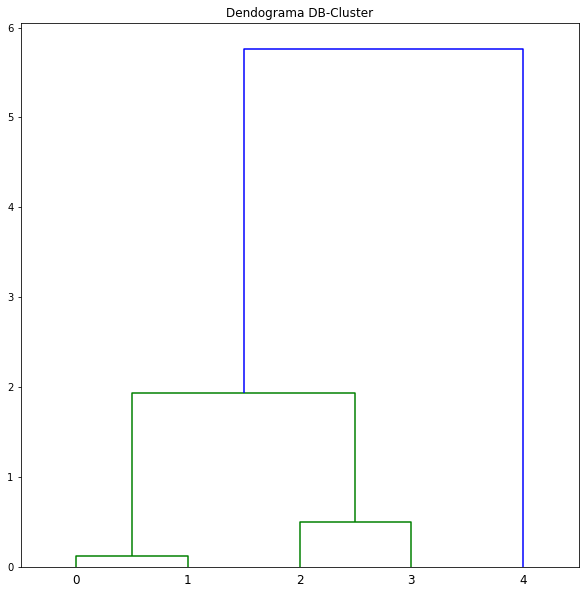

In [5]:
Z=dbCluster(D)
plt.figure(figsize=(10,10))
plt.title("Dendograma DB-Cluster")
dendrogram(Z)
print("Linkage:", Z)
plt.show()

## KMeans - Ward

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris as iris
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score

In [7]:
'''Función que devuelve la tasa de aciertos de la predicción hecha por KMeans + Ward a los baricentros'''
def wardKmeans(D, k=6, l=9, random=None):
    
    #Cargamos datos y predecimos los clusters con KMeans
    X = StandardScaler().fit_transform(D.data)
    Y = D.target
    kmeans = KMeans(n_clusters=k+l, random_state=random)
    clusts = kmeans.fit_predict(X)

    #Calculamos los k+l baricentros de los clusters predichos por KMeans
    bar = []
    for i in range(k+l):
        bar.append(np.mean(X[np.argwhere(clusts==i)], 0)[0])
        
    #Aplicamos ward para k clusters sobre los k+l baricentros
    ac = AgglomerativeClustering(n_clusters=k, linkage="ward", affinity="euclidean")
    ward = ac.fit_predict(bar)

    #Cambiamos los k+l clusters de KMeans a los k aglomerados por Ward
    for i in range(k):  
        c = np.where(ward==i)[0]
        for j in c:
            clusts = np.where(c es custs==j, i+k+l, clusts)
    clusts -= k+l
    
    #Calculamos la moda de los k clusters aglomerados
    moda = np.zeros(k, dtype='int')
    for i in range(k):
        moda[i] = mode(Y[np.argwhere(clusts==i)])[0].astype(int)
    
    pred = moda[clusts]

    #Calculamos la tasa de aciertos de la clasificación
    score = accuracy_score(pred, Y)
    
    return score

In [8]:
print("Tasa de error KMeans-Ward para Iris: ", wardKmeans(iris(), random=0))

Tasa de error KMeans-Ward para Iris:  0.8066666666666666
